In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib notebook

The best-fit value for the ('forward') slope and intercept are: 2.2399 +/- 0.1345 and 34.0477 +/- 22.7656
The best-fit value for the ('forward') slope and intercept are: 2.6352 +/- 0.2753 and -49.9429 +/- 44.4360
The best-fit value for the ('reverse') slope and intercept are: 2.6352 and -49.9429
The best-fit value for the slope and intercept are: 2.2399 and 34.0477
2.2399208316310926 34.047727757542816


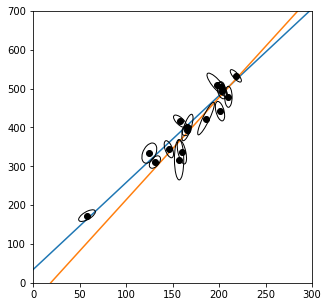

In [40]:
obs_x = np.array([203, 58, 210, 202, 198, 158, 
                165, 201, 157, 131, 166, 160, 
                186, 125, 218, 146])
obs_y = np.array([495, 173, 479, 504, 510, 416, 
                393, 442, 317, 311, 400, 337, 
                423, 334, 533, 344])
sigma_x = np.array([5, 9, 4, 4, 11, 7, 
                    5, 5, 5, 6, 6, 5, 
                    9, 8, 6, 5])
sigma_y = np.array([21, 15, 27, 14, 30, 16, 
                    14, 25, 52, 16, 34, 31, 
                    42, 26, 16, 22])
rho_xy = np.array([-0.33, 0.67, -0.02, -0.05, -0.84, -0.69,
                    0.30, -0.46, -0.03, 0.50, 0.73, -0.52, 
                    0.90, 0.40, -0.78, -0.56])


def plotData(ax, x, y, xerr, yerr, rhoxy, zorder = 10):
    
    #ax.errorbar(x, y, xerr = sigma_x, yerr = sigma_y, fmt = "o", capsize=3)
    ax.scatter(x, y, color = 'black', zorder = 10)
    for (xx, yy, sx, sy, rxy) in zip(x,y,sigma_x, sigma_y, rho_xy):
        #from here: https://www.unige.ch/sciences/astro/files/5413/8971/4090/2_Segransan_StatClassUnige.pdf
        #also here: http://www.cs.utah.edu/~tch/CS4300/resources/refs/ErrorEllipses.pdf
        #find better reference
        cov = np.array([[ sx**2, rxy*sx*sy],
                        [rxy*sx*sy, sy**2.]])
        w, v  = np.linalg.eig(cov)
        theta = np.arctan(2. * rxy * sx * sy / (sx**2. - sy**2.))/2.
        ax.add_artist(Ellipse((xx, yy), 2.*w[0]**0.5, 2.*w[1]**0.5, \
                              angle = np.rad2deg(theta),\
                              facecolor="none", edgecolor="black", zorder = zorder))
        
f, ax = plt.subplots(1, figsize = (5,5))

plotData(ax, obs_x, obs_y, sigma_x, sigma_y, rho_xy)
ax.set_xlim(0,300)
ax.set_ylim(0,700)

#"abominable" forward–reverse fitting procedure
#DON'T DO THIS!
#polyfit with uncertainties on y ("forward")
p_xy, pcov = np.polyfit(obs_x, obs_y, 1, w = 1./sigma_y, cov = True)
err_xy = np.sqrt(np.diag(pcov))
p_xy_eval = np.poly1d(p_xy)
print("The best-fit value for the ('forward') slope and intercept are: {:.4f} +/- {:.4f} and {:.4f} +/- {:.4f}"\
      .format(p_xy[0], err_xy[0], p_xy[1], err_xy[1]))
ax.plot([0,300],p_xy_eval([0,300]),color='C0')

#polyfit with uncertainties on x ("reverse")
p_yx, pcov = np.polyfit(obs_y, obs_x, 1, w = 1./sigma_x, cov = True)
err_yx = np.sqrt(np.diag(pcov))
p_yx_eval = np.poly1d(p_yx)
inv = [1./p_yx[0], -p_yx[1]/p_yx[0]]
inv_err = [inv[0]**2.*err_yx[0],  (p_yx[0]**-2 * err_yx[1]**2. + (p_yx[1]/p_yx[0]**2.)**2. * err_yx[0]**2.)**0.5]
print("The best-fit value for the ('forward') slope and intercept are: {:.4f} +/- {:.4f} and {:.4f} +/- {:.4f}"\
      .format(inv[0], inv_err[0], inv[1], inv_err[1]))
print("The best-fit value for the ('reverse') slope and intercept are: {:.4f} and {:.4f}".format(1./p_yx[0], -p_yx[1]/p_yx[0]))
ax.plot(p_yx_eval([0.,700.]), [0.,700.],color='C1')

#a little bit more thorough (see Adams' problem 2e and notes above)
Y = obs_y.reshape(-1,1)
A = np.vstack((np.ones_like(obs_x), obs_x)).T
C = np.diag(sigma_y**2)

X = np.linalg.inv(A.transpose()@np.linalg.inv(C)@A) @ (A.transpose()@np.linalg.inv(C)@Y)

best_fit = np.poly1d(X[::-1,0])
print("The best-fit value for the slope and intercept are: {:.4f} and {:.4f}".format(X[1][0], X[0][0]))

mFreq = X[1][0]
bFreq = X[0][0]


#from emcee website
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, obs_y)))
print(m_ls,b_ls)




In [41]:
def lnlike(theta, x, y, xerr, yerr, rhoxy):
    th, bperp = theta
    lnl = 0.
    v = np.array([[-np.sin(th)], [np.cos(th)]])
    vT = v.transpose()
    for (xx, yy, sx, sy, rxy) in zip(x, y, xerr, yerr, rhoxy):
        S = np.array([[ sx**2, rxy*sx*sy],
                    [rxy*sx*sy, sy**2.]]) 

        Z = np.array([[xx],[yy]])
        Delta = vT @ Z - bperp
        Epsilon2 = vT @ S @ v
        lnl -= Delta**2. / (2. * Epsilon2) 

    return lnl.squeeze()

def lnprior(theta):
    th, bperp = theta
    if ( (0 < np.abs(th) < 2.*np.pi) and (-200 < bperp < 200)):
        return 0.0
    return -np.inf

def lnprob(theta, x, y, xerr, yerr, rhoxy):
    lnp = lnprior(theta)
    lnl = lnlike(theta,  x, y, xerr, yerr, rhoxy)
    if (not np.isfinite(lnp) or not np.isfinite(lnl)):
        return -np.inf
    return lnp + lnl

def thFromM(m):
    return np.arctan(m)
def bpFromBth(b, th):
    return b * np.cos(th)
def mFromTh(th):
    return np.tan(th)
def bFromThBp(th, bp):
    return bp/np.cos(th)

Optimization terminated successfully.
The initial guess for the slope and intercept are: 2.2399 and 34.0477
The best-fit value for the slope and intercept are: 2.2005 and 35.9472


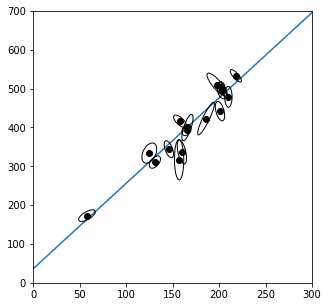

In [42]:
from scipy.optimize import leastsq, minimize

def lkeList(theta, x, y, xerr, yerr, rhoxy):
    outlist = [np.exp(-lnlike(theta, [xx], [yy], [xxe], [yye], [rxy])) for (xx,yy,xxe,yye,rxy) in zip(x, y, xerr, yerr, rhoxy)]
    return outlist

def ilnlike(theta, x, y, xerr, yerr, rhoxy):
    return -lnlike(theta, x, y, xerr, yerr, rhoxy)

guess0 = np.array([thFromM(mFreq), bpFromBth(bFreq, thFromM(mFreq))])
#scFit = leastsq(lkeList, guess0, args=(obs_x, obs_y, sigma_x, sigma_y, rho_xy), full_output=1)
scFit = minimize(ilnlike, guess0, args=(obs_x, obs_y, sigma_x, sigma_y, rho_xy))
print(scFit.message)

f, ax = plt.subplots(1, figsize = (5,5))

plotData(ax, obs_x, obs_y, sigma_x, sigma_y, rho_xy)
mSci = mFromTh(scFit.x[0])
bSci = bFromThBp(scFit.x[0], scFit.x[1])
ax.plot( [0.,700.], mSci*np.array([0.,700.]) + bSci, color='C0')

ax.set_xlim(0,300)
ax.set_ylim(0,700)

#can I get the uncertainties on these parameters?
#pcov = scFit[1]
#perr = np.sqrt(np.diag(pcov))
#th, bp = scFit[0][0], scFit[0][1]
#err = [np.cos(th)**-2. * perr[0], (np.cos(th)**-2. * perr[1]**2. + (bp/np.sin(th))**2. * perr[0]**2.)**0.5]
print("The initial guess for the slope and intercept are: {:.4f} and {:.4f}"\
      .format(mFromTh(guess0[0]), bFromThBp(guess0[0], guess0[1])))
#print("The best-fit value for the slope and intercept are: {:.4f} +/- {:.4f} and {:.4f} +/- {:.4f}"\
#      .format(mFromTh(th), err[0], bFromThBp(th, bp), err[1]))
print("The best-fit value for the slope and intercept are: {:.4f} and {:.4f}".format(mSci, bSci))


In [43]:
nwalkers = 100
#guess0 = np.array(thFromM(mSci), bpFromBth(bSci, thFromM(mSci))])
guess0 = np.array([thFromM(mFreq), bpFromBth(bFreq, thFromM(mFreq))])
nfac = [1e-2, 1e-2]
ndim = len(guess0)
pos = [guess0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(obs_x, obs_y, sigma_x, sigma_y, rho_xy))

nsamples = 2000
foo = sampler.run_mcmc(pos, nsamples)

emcee results with 1-sigma uncertainties
       m = 2.1937 +0.1240 -0.1132
       b = 36.8231 +18.6207 -20.1367



Text(0.5,0,'x')

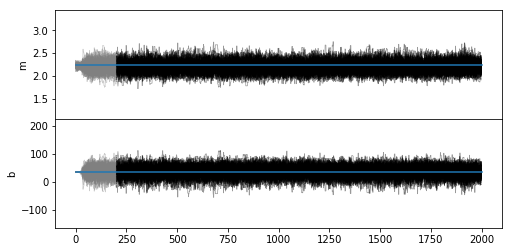

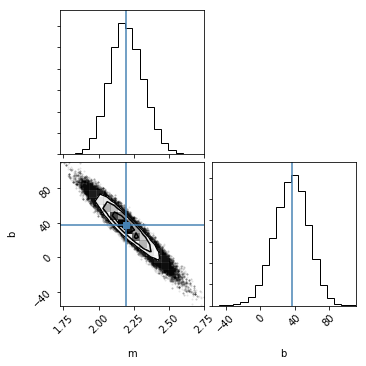

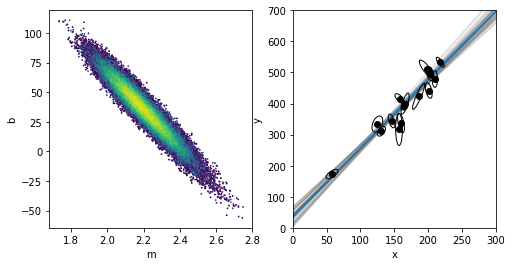

In [44]:
nburn = 200
th_samples = np.array(sampler.chain[:,nburn:,0]).flatten()
bp_samples = np.array(sampler.chain[:,nburn:,1]).flatten()
#V_samples = np.array(sampler.chain[:,nburn:,2]).flatten()
m_samples = mFromTh(th_samples)
b_samples = bFromThBp(th_samples, bp_samples)

samples = np.vstack([m_samples, b_samples]).T
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      m = {:.4f} +{:.4f} -{:.4f}\n \
      b = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(m_mcmc[0], m_mcmc[1], m_mcmc[2], b_mcmc[0], b_mcmc[1], b_mcmc[2]))

#chains
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (8,4), sharex = True)
ax1.set_ylabel("m")
ax2.set_ylabel("b")
afac = 10.
ax1.set_ylim(m_mcmc[0] - afac*m_mcmc[2], m_mcmc[0] + afac*m_mcmc[1])
ax2.set_ylim(b_mcmc[0] - afac*b_mcmc[2], b_mcmc[0] + afac*b_mcmc[1])
fig.subplots_adjust(hspace = 0)
xplot = range(nsamples)
ax1.plot([0, nsamples],[mFreq, mFreq], color = 'C0', zorder = 10)
ax2.plot([0, nsamples],[bFreq, bFreq], color = 'C0', zorder = 10)
for w in range(nwalkers - 1):
    th_sample = sampler.chain[w,:nburn,0]
    bp_sample = sampler.chain[w,:nburn,1]
    ax1.plot(xplot[:nburn], mFromTh(th_sample), color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
    ax2.plot(xplot[:nburn], bFromThBp(th_sample, bp_sample), color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
    th_sample = sampler.chain[w,nburn:,0]
    bp_sample = sampler.chain[w,nburn:,1]
    ax1.plot(xplot[nburn:], mFromTh(th_sample), color="k", alpha = 0.4, lw = 0.7, zorder = 1)
    ax2.plot(xplot[nburn:], bFromThBp(th_sample, bp_sample), color="k", alpha = 0.4, lw = 0.7, zorder = 1)

#corner plot
import corner
corner.corner(samples, labels = ['m','b'], truths = [m_mcmc[0], b_mcmc[0]])


#Adam's plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))

ax1.hexbin(m_samples, b_samples, gridsize = 250, bins = "log", mincnt = 1)
plotData(ax2, obs_x, obs_y, sigma_x, sigma_y, rho_xy)
ax2.set_xlim(0,300)
ax2.set_ylim(0,700)


max_prob = np.argmax(sampler.flatlnprobability)
th_max = sampler.flatchain[:,0][max_prob]
bp_max = sampler.flatchain[:,1][max_prob]
m_max = mFromTh(th_max)
b_max = bFromThBp(th_max, bp_max)
ax2.plot([0,300], [b_max + 0*m_max, b_max + 300*m_max], lw = 2, zorder = 2)

ndraw = 50
for rand_draw in np.random.randint(500, len(sampler.flatchain[:,0]), ndraw):
    th_draw = sampler.flatchain[:,0][rand_draw]
    bp_draw = sampler.flatchain[:,1][rand_draw]
    m_draw = mFromTh(th_draw)
    b_draw = bFromThBp(th_draw, bp_draw)
    ax2.plot([0,300], [b_draw + 0*m_draw, b_draw + 300*m_draw],
             color = "0.5", alpha = 0.4, lw = 0.7, zorder = 1)

ax1.set_xlabel("m")
ax1.set_ylabel("b")
ax2.set_ylabel("y")
ax2.set_xlabel("x")

Desired error not necessarily achieved due to precision loss.
The best-fit value for the slope and intercept are: 1.3266 and 163.8365


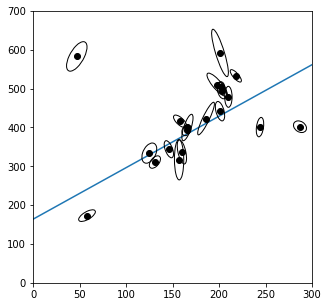

In [45]:
obs_x = np.array([201, 244, 47, 287, 
                  203, 58, 210, 202, 198, 158, 
                165, 201, 157, 131, 166, 160, 
                186, 125, 218, 146])
obs_y = np.array([592, 401, 583, 402, 
                  495, 173, 479, 504, 510, 416, 
                393, 442, 317, 311, 400, 337, 
                423, 334, 533, 344])
sigma_x = np.array([9, 4, 11, 7, 
                    5, 9, 4, 4, 11, 7, 
                    5, 5, 5, 6, 6, 5, 
                    9, 8, 6, 5])
sigma_y = np.array([61, 25, 38, 15,
                    21, 15, 27, 14, 30, 16, 
                    14, 25, 52, 16, 34, 31, 
                    42, 26, 16, 22])
rho_xy = np.array([-0.84, 0.31, 0.64, -0.27,
                   -0.33, 0.67, -0.02, -0.05, -0.84, -0.69,
                    0.30, -0.46, -0.03, 0.50, 0.73, -0.52, 
                    0.90, 0.40, -0.78, -0.56])

guess0 = np.array([thFromM(mFreq), bpFromBth(bFreq, thFromM(mFreq))])
scFit = minimize(ilnlike, guess0, args=(obs_x, obs_y, sigma_x, sigma_y, rho_xy))
print(scFit.message)

f, ax = plt.subplots(1, figsize = (5,5))

plotData(ax, obs_x, obs_y, sigma_x, sigma_y, rho_xy)
mSci = mFromTh(scFit.x[0])
bSci = bFromThBp(scFit.x[0], scFit.x[1])
ax.plot( [0.,700.], mSci*np.array([0.,700.]) + bSci, color='C0')

ax.set_xlim(0,300)
ax.set_ylim(0,700)

print("The best-fit value for the slope and intercept are: {:.4f} and {:.4f}".format(mSci, bSci))


In [49]:
##modify this to prune the outliers

def lnlike(theta, x, y, xerr, yerr, rhoxy):
    th, bperp, pb, xb, vxb, yb, vyb  = theta
    lnl = 0.

    v = np.array([[-np.sin(th)], [np.cos(th)]])
    vT = v.transpose()

    #bad data
    #assuming rxy for the bad data is 1.
    S = np.array([[ vxb, vxb**0.5*vyb**0.5],
            [vxb**0.5*vyb**0.5, vyb]]) 
    Z = np.array([[xb],[yb]])
    Delta = vT @ Z - bperp
    Epsilon2 = vT @ S @ v
    lnlBad = Delta**2. / (2. * Epsilon2) 
    
    for (xx, yy, sx, sy, rxy) in zip(x, y, xerr, yerr, rhoxy):
        #good data
        S = np.array([[ sx**2, rxy*sx*sy],
                    [rxy*sx*sy, sy**2.]]) 
        Z = np.array([[xx],[yy]])
        Delta = vT @ Z - bperp
        Epsilon2 = vT @ S @ v
        lnlGood = Delta**2. / (2. * Epsilon2) 
        
        

        lnl -= (1. - pb) * lnlGood - pb * lnlBad
        
    return lnl.squeeze()

def lnprior(theta):
    th, bperp, pb, xb, vxb, yb, vyb,  = theta
    if ( (0 < np.abs(th) < 2.*np.pi) and (-200 < bperp < 200) and (0 < pb < 1.0) and \
        (0 < vxb < 1000.) and (-1000 < xb < 1000) and \
        (0 < vyb < 1000.) and (-1000 < yb < 1000) ):
        return 0.0
    return -np.inf


In [57]:
nwalkers = 100
#guess0 = scFit[0]
guess0 = np.array([thFromM(mFreq), bpFromBth(bFreq, thFromM(mFreq)), 0.2, 5., 0., 5., 0.])
nfac = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
ndim = len(guess0)
pos = [guess0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(obs_x, obs_y, sigma_x, sigma_y, rho_xy))

nsamples = 5000
foo = sampler.run_mcmc(pos, nsamples)

/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


emcee results with 1-sigma uncertainties
       m = 2.2404 +0.0807 -0.0772
       b = 34.0590 +1.0177 -0.9819



Text(0.5,0,'x')

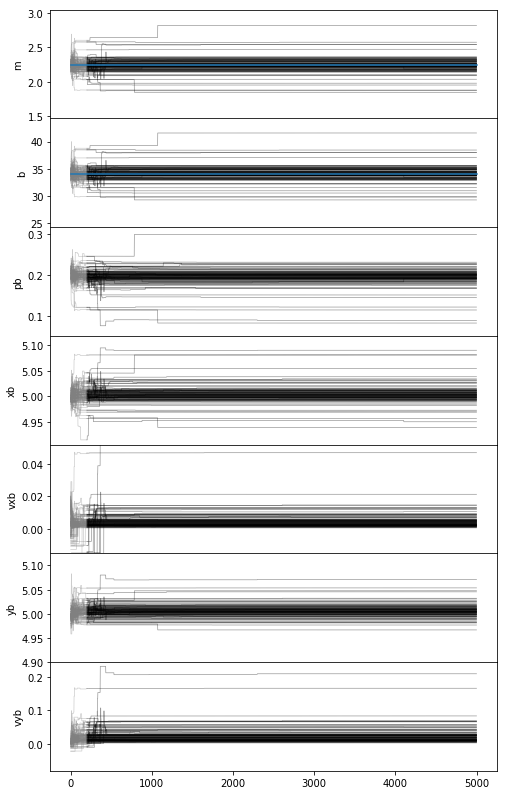

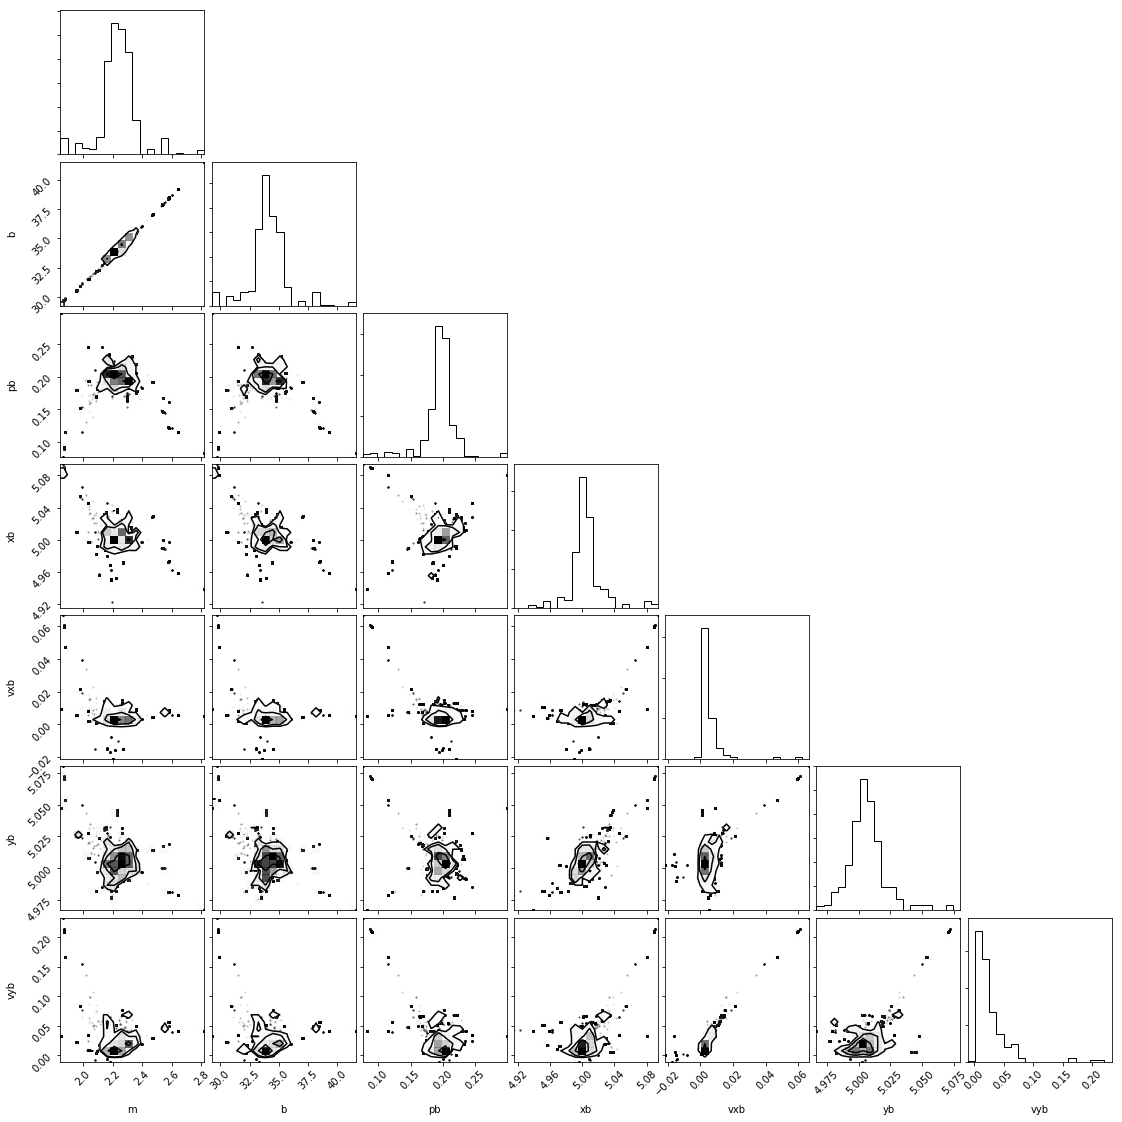

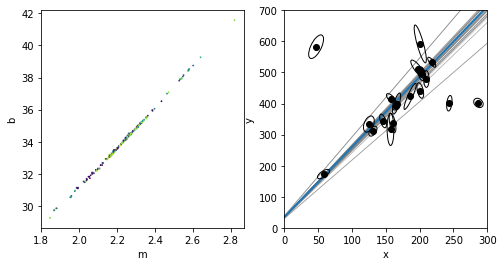

In [58]:
nburn = 200
th_samples = np.array(sampler.chain[:,nburn:,0]).flatten()
bp_samples = np.array(sampler.chain[:,nburn:,1]).flatten()
pb_samples = np.array(sampler.chain[:,nburn:,2]).flatten()
xb_samples = np.array(sampler.chain[:,nburn:,3]).flatten()
vxb_samples = np.array(sampler.chain[:,nburn:,4]).flatten()
yb_samples = np.array(sampler.chain[:,nburn:,5]).flatten()
vyb_samples = np.array(sampler.chain[:,nburn:,6]).flatten()
m_samples = mFromTh(th_samples)
b_samples = bFromThBp(th_samples, bp_samples)

samples = np.vstack([m_samples, b_samples, pb_samples, xb_samples, vxb_samples, yb_samples, vyb_samples]).T
m_mcmc, b_mcmc, pb_mcmc, xb_mcmc, vxb_mcmc, yb_mcmc, vyb_mcmc = \
    map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      m = {:.4f} +{:.4f} -{:.4f}\n \
      b = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(m_mcmc[0], m_mcmc[1], m_mcmc[2], b_mcmc[0], b_mcmc[1], b_mcmc[2]))

#chains
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7,1, figsize = (8,14), sharex = True)
ax1.set_ylabel("m")
ax2.set_ylabel("b")
ax3.set_ylabel("pb")
ax4.set_ylabel("xb")
ax5.set_ylabel("vxb")
ax6.set_ylabel("yb")
ax7.set_ylabel("vyb")
afac = 10.
ax1.set_ylim(m_mcmc[0]   - afac*m_mcmc[2],   m_mcmc[0]   + afac*m_mcmc[1])
ax2.set_ylim(b_mcmc[0]   - afac*b_mcmc[2],   b_mcmc[0]   + afac*b_mcmc[1])
ax3.set_ylim(pb_mcmc[0]  - afac*pb_mcmc[2],  pb_mcmc[0]  + afac*pb_mcmc[1])
ax4.set_ylim(xb_mcmc[0]  - afac*xb_mcmc[2],  xb_mcmc[0]  + afac*xb_mcmc[1])
ax5.set_ylim(vxb_mcmc[0] - afac*vxb_mcmc[2], vxb_mcmc[0] + afac*vxb_mcmc[1])
ax6.set_ylim(yb_mcmc[0]  - afac*yb_mcmc[2],  yb_mcmc[0]  + afac*yb_mcmc[1])
ax7.set_ylim(vyb_mcmc[0] - afac*vyb_mcmc[2], vyb_mcmc[0] + afac*vyb_mcmc[1])
fig.subplots_adjust(hspace = 0)
xplot = range(nsamples)
ax1.plot([0, nsamples],[mFreq, mFreq], color = 'C0', zorder = 10)
ax2.plot([0, nsamples],[bFreq, bFreq], color = 'C0', zorder = 10)
for w in range(nwalkers - 1):
    th_sample = sampler.chain[w,:nburn,0]
    bp_sample = sampler.chain[w,:nburn,1]
    ax1.plot(xplot[:nburn], mFromTh(th_sample), color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
    ax2.plot(xplot[:nburn], bFromThBp(th_sample, bp_sample), color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
    ax3.plot(xplot[:nburn], sampler.chain[w,:nburn,2], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
    ax4.plot(xplot[:nburn], sampler.chain[w,:nburn,3], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
    ax5.plot(xplot[:nburn], sampler.chain[w,:nburn,4], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
    ax6.plot(xplot[:nburn], sampler.chain[w,:nburn,5], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
    ax7.plot(xplot[:nburn], sampler.chain[w,:nburn,6], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
    th_sample = sampler.chain[w,nburn:,0]
    bp_sample = sampler.chain[w,nburn:,1]
    ax1.plot(xplot[nburn:], mFromTh(th_sample), color="k", alpha = 0.4, lw = 0.7, zorder = 1)
    ax2.plot(xplot[nburn:], bFromThBp(th_sample, bp_sample), color="k", alpha = 0.4, lw = 0.7, zorder = 1)
    ax3.plot(xplot[nburn:], sampler.chain[w,nburn:,2], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
    ax4.plot(xplot[nburn:], sampler.chain[w,nburn:,3], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
    ax5.plot(xplot[nburn:], sampler.chain[w,nburn:,4], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
    ax6.plot(xplot[nburn:], sampler.chain[w,nburn:,5], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
    ax7.plot(xplot[nburn:], sampler.chain[w,nburn:,6], color="k", alpha = 0.4, lw = 0.7, zorder = 1)

#corner plot
import corner
corner.corner(samples, labels = ['m','b', 'pb','xb','vxb','yb','vyb'])#, truths = [m_mcmc[0], b_mcmc[0]])


#Adam's plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))

ax1.hexbin(m_samples, b_samples, gridsize = 250, bins = "log", mincnt = 1)
plotData(ax2, obs_x, obs_y, sigma_x, sigma_y, rho_xy)
ax2.set_xlim(0,300)
ax2.set_ylim(0,700)


max_prob = np.argmax(sampler.flatlnprobability)
th_max = sampler.flatchain[:,0][max_prob]
bp_max = sampler.flatchain[:,1][max_prob]
m_max = mFromTh(th_max)
b_max = bFromThBp(th_max, bp_max)
ax2.plot([0,300], [b_max + 0*m_max, b_max + 300*m_max], lw = 2, zorder = 2)

ndraw = 50
for rand_draw in np.random.randint(500, len(sampler.flatchain[:,0]), ndraw):
    th_draw = sampler.flatchain[:,0][rand_draw]
    bp_draw = sampler.flatchain[:,1][rand_draw]
    m_draw = mFromTh(th_draw)
    b_draw = bFromThBp(th_draw, bp_draw)
    ax2.plot([0,300], [b_draw + 0*m_draw, b_draw + 300*m_draw],
             color = "0.5", alpha = 0.4, lw = 0.7, zorder = 1)

ax1.set_xlabel("m")
ax1.set_ylabel("b")
ax2.set_ylabel("y")
ax2.set_xlabel("x")

In [1]:
import pandas as pd
from IPython.display import display

In [67]:
#data from : http://adsabs.harvard.edu/abs/2009ApJ...698..198G
#Table 1
mSigma = pd.read_csv('apj303542t1_ascii.txt', quotechar='"', sep='\t')
print(mSigma.columns.values)
display(mSigma)

def fixSci(series):
    x = series.str.split(' ', expand = True)
    x2 = x[:][2].str.split('^', expand = True)
    return(x[:][0].astype("float") * 10.**x2[:][1].astype("float"))

def fixSig(series):
    x = series.str.split(' ', expand = True)
    return(x[:][0].astype("float"))
def fixSige(series):
    x = series.str.split(' ', expand = True)
    x2 = x[:][2].str.split('^', expand = True)
    return(x2[:][0].astype("float"))

obs_x = np.array(fixSci(mSigma['M_BH (M_sun)']))
obs_y = np.array(fixSig(mSigma['sigma_e (km s^-1)']))
sigma_y = np.array(fixSige(mSigma['sigma_e (km s^-1)']))
x_low = np.array(fixSci(mSigma['M_low (M_sun)']))
x_high = np.array(fixSci(mSigma['M_high (M_sun)']))
sigma_x_low = x_obs - x_low
sigma_x_high = x_high - x_obs
rho_xy = np.full_like(x_obs, 0.)

#Obviously not what we'd want to do
sigma_x = np.array([ (x1 + x2)/2. for (x1, x2) in zip(sigma_x_low, sigma_x_high)])

['Galaxy' 'Type^a' 'Dist. (Mpc)' 'M_BH (M_sun)' 'M_low (M_sun)'
 'M_high (M_sun)' 'Method, Ref.' 'sigma_e (km s^-1)' 'M^0_V,T'
 'M^0_V,bulge^b' 'R_infl/d_res' 'Samp.' 'Unnamed: 12']


,Galaxy,Type^a,Dist. (Mpc),M_BH (M_sun),M_low (M_sun),M_high (M_sun),"Method, Ref.",sigma_e (km s^-1),"M^0_V,T","M^0_V,bulge^b",R_infl/d_res,Samp.,Unnamed: 12
0,"Circinus^c,^d",Sb,4.000,1.7 x 10^6,1.4 x 10^6,2.1 x 10^6,"Maser, 1",158 +or- 18^d,-17.36,...,6.06,S,NaN
1,IC1459^e,E4,30.900,2.8 x 10^9,1.6 x 10^9,3.9 x 10^9,"Stars, 2",340 +or- 17,-22.57,-22.57 +or- 0.15,0.56,S,NaN
2,"MW^f,^g",Sbc,0.008,4.1 x 10^6,3.5 x 10^6,4.7 x 10^6,"Stars, 3",105 +or- 20,...,...,20622.00,S,NaN
3,N0221 M32,E2,0.860,3.1 x 10^6,2.5 x 10^6,3.7 x 10^6,"Stars, 4",75 +or- 3,-16.83,-16.83 +or- 0.05,12.20,RS,NaN
4,N0224 M31,Sb,0.800,1.5 x 10^8,1.2 x 10^8,2.4 x 10^8,"Stars, 5",160 +or- 8,-21.84,...,113.00,S,NaN
5,N0821^h,E4,25.500,4.2 x 10^7,3.4 x 10^7,7.0 x 10^7,"Stars, 6",209 +or- 10,-21.24,-21.24 +or- 0.13,0.33,S,NaN
6,N1023,SB0,12.100,4.6 x 10^7,4.1 x 10^7,5.1 x 10^7,"Stars, 7",205 +or- 10,-21.26,-20.61 +or- 0.28,0.81,S,NaN
7,"N1068^g,^i M77",Sb,15.400,8.6 x 10^6,8.3 x 10^6,8.9 x 10^6,"Maser, 8",151 +or- 7,-22.17,...,22.50,S,NaN
8,N1300^g,SB(rs)bc,20.100,7.1 x 10^7,3.6 x 10^7,1.4 x 10^8,"Gas, 9",218 +or- 10,-21.34,...,0.65,S,NaN
9,N1399^j,E1,21.100,5.1 x 10^8,4.4 x 10^8,5.8 x 10^8,"Stars, 10",337 +or- 16,-22.13,-22.13 +or- 0.10,1.82,S,NaN


<IPython.core.display.Javascript object>


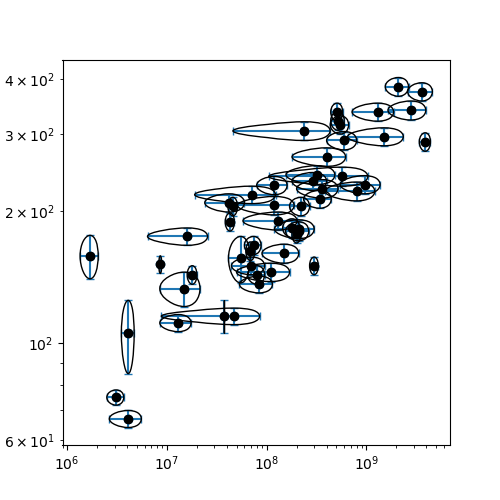

51 51 51 51


In [72]:
f, ax = plt.subplots(1, figsize = (5,5))
print(len(obs_x), len(obs_y), len(sigma_x), len(sigma_y))
ax.errorbar(obs_x, obs_y, xerr = sigma_x, yerr = sigma_y, fmt = "o", capsize=3)
plotData(ax, obs_x, obs_y, sigma_x, sigma_y, rho_xy)
ax.set_xscale("log")
ax.set_yscale("log")
